<a href="https://colab.research.google.com/github/hmaccelerate/INFO7374/blob/master/Assignment2/Experiment3_AlexNet_on_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# use following command to make colab connect google drive
#The maximum lifetime of a Colab VM is 12 hours.
!dpkg --configure -a
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [3]:
!ls /content
# zip the imagenet file
# !7z x /content/drive/ColabWorkSpaces/INFO7374/Assignment2/tiny-imagenet-200-32.zip
# !pip install h5py

adc.json  drive  sample_data


In [4]:
# Requirement
# Implement the Alexnet models in Keras. Summarize Accuracy measures for Train, Test and 
# Validation for the best model
#coding=utf-8
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Activation
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
import numpy as np 
import pandas as pd
from keras.preprocessing import image
import functools
import os
import gc
import pickle
from keras.models import load_model
from keras.callbacks import EarlyStopping

# from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [5]:
# load tiny imagenet data
data_path = '/content/tiny-imagenet-200-32/'
train_data_path = '/content/tiny-imagenet-200-32/train/'
test_data_path = '/content/tiny-imagenet-200-32/test/box/'
val_data_path = '/content/tiny-imagenet-200-32/val/box/'

train_data = []
train_label = []
label_dict = dict()

val_data = []
val_label = []

train_exist=os.path.exists('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/train_data.npy')
if train_exist:
  print('exist: load the data')
  train_data=np.load('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/train_data.npy')
  train_label=np.load('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/train_label.npy')
else:
  print('does not exist')
  classes = os.listdir(train_data_path)
  for i in range(len(classes)):
      label_dict[classes[i]]=i
      path = train_data_path+classes[i]+'/images/'
      image_names = os.listdir(path)
      for name in image_names:
        image_path = path+name
        x = image.load_img(image_path)
        x = image.img_to_array(x)
        train_data.append(x)
        train_label.append(i)
        print(image_path)
      
  train_data = np.asarray(train_data)
  train_label=np.asarray(train_label)
  np.save('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/train_data.npy',train_data)
  np.save('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/train_label.npy',train_label)

exist: load the data


In [6]:
val_exist=os.path.exists('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/val_data.npy')
if val_exist:
  print('exist: load the data')
  val_data=np.load('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/val_data.npy')
  val_label=np.load('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/val_label.npy')
else:
  val_image_names = os.listdir(val_data_path)
  def cmp(a, b):
      a =int(a[4:len(a)-4])
      b = int(b[4:len(b)-4])
      if b < a:
          return 1
      if a < b:
          return -1
      return 0

  val_image_names =sorted(val_image_names, key=functools.cmp_to_key(cmp))
  for val_name in val_image_names:
        val_image_path = val_data_path+val_name
        x = image.load_img(val_image_path)
        x = image.img_to_array(x)
        val_data.append(x)
        print(val_image_path)

  val_annotations = pd.read_csv('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/val_annotations.txt', sep="\t", header=None)
  val_image_type = val_annotations[:][1]
  for item in val_image_type:
    print(item)
    i=label_dict[item]
    val_label.append(i)

  val_data = np.asarray(val_data)
  val_label=np.asarray(val_label)
  np.save('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/val_data.npy',val_data)
  np.save('/content/drive/ColabWorkSpaces/INFO7374/Assignment2/imagenet_data/val_label.npy',val_label)

exist: load the data


In [7]:
x_train=train_data
y_train=train_label
x_test=val_data
y_test=val_label

del train_data
del train_label
del val_data
del val_label
gc.collect()

506

In [8]:
#1. Preparing the data
# The data, split between train and test sets:
num_classes=200
# print the shape information
print('single item shape:',x_train[0].shape)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# change the type： float32 for GPU computations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# # normalize the data
x_train /= 255
x_test /= 255

# # Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

single item shape: (32, 32, 3)
x_train shape: (100000, 32, 32, 3)
100000 train samples
10000 test samples


In [0]:
seed = 7
np.random.seed(seed)

def alexnet(x_train,y_train,x_test,y_test,epochs,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate):
#   build the model
  model = Sequential()
  
  # 1st Convolutional Layer
  model.add(Conv2D(filters=conv_filters_list[0],kernel_size=(5,5),strides=conv_strides,input_shape=(32,32,3),padding='valid',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
  model.add(MaxPooling2D(pool_size=(3,3),strides=pooling_strides))

  # 2st Convolutional Layer
  model.add(Conv2D(conv_filters_list[1],(4,4),strides=conv_strides,padding='same',activation='relu',kernel_initializer='uniform'))
  model.add(MaxPooling2D(pool_size=(5,5),strides=pooling_strides))
  
  # 3st Convolutional Layer
  model.add(Conv2D(conv_filters_list[2],(3,3),strides=conv_strides,padding='same',activation='relu',kernel_initializer='uniform'))
  
  # 4st Convolutional Layer
  model.add(Conv2D(conv_filters_list[3],(3,3),strides=conv_strides,padding='same',activation='relu',kernel_initializer='uniform'))
  
  # 5st Convolutional Layer
  model.add(Conv2D(conv_filters_list[4],(3,3),strides=conv_strides,padding='same',activation='relu',kernel_initializer='uniform'))
  
  model.add(MaxPooling2D(pool_size=(3,3),strides=pooling_strides))
  model.add(Flatten())
  
  # 1st Dense Layer
  model.add(Dense(dense_filters_list[0],activation='relu'))
  model.add(Dropout(drop_out_rate))
  
  # 2st Dense Layer
  model.add(Dense(dense_filters_list[1],activation='relu'))
  model.add(Dropout(drop_out_rate))
  
  # 3st Dense Layer
  model.add(Dense(200,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  model.summary()
  
  early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
  history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True,
                callbacks=[early_stopping])
  
# Score trained model.
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  
#   return history
  return (model,history, scores[0],scores[1])
# feature map must be smaller than input shape size

In [0]:
# Util Fuctions
def plot_accuracy_loss(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.legend()
  plt.show()


  
def write_result(exper_result,path):
  with open(path, 'wb') as f:  # Python 3: open(..., 'wb')
      pickle.dump(exper_result, f)
      f.close()
      
def load_result(path):
  # Getting back the objects:
  with open(path,'rb') as f:  # Python 3: open(..., 'rb')
      exper_result = pickle.load(f)  
      f.close()
      return exper_result

  
base_path='/content/drive/ColabWorkSpaces/INFO7374/Assignment2/result/alexnet/'
model_base_path='/content/drive/ColabWorkSpaces/INFO7374/Assignment2/model/alexnet/'

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_4 (Conv2D)    

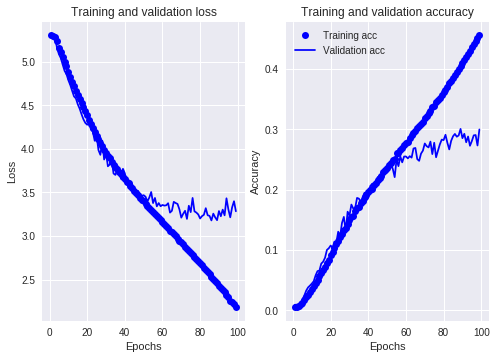

4648

In [0]:
# Exp 1
epoch =100
batch_size =256
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result1.txt')
result[0].save(model_base_path+'model1.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 5, 5, 256)         884992    
__________

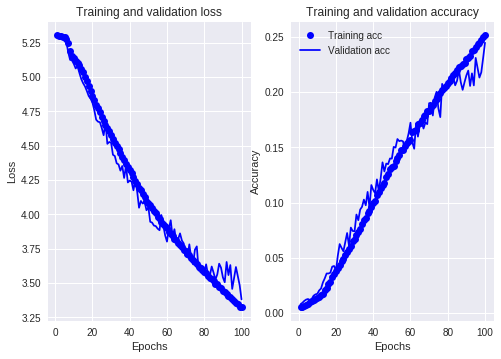

4885

In [0]:
# Exp2
epoch =100
batch_size =512
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result2.txt')
result[0].save(model_base_path+'model2.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 5, 5, 256)         884992    
__________

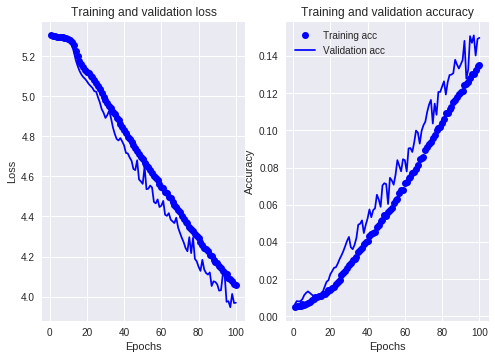

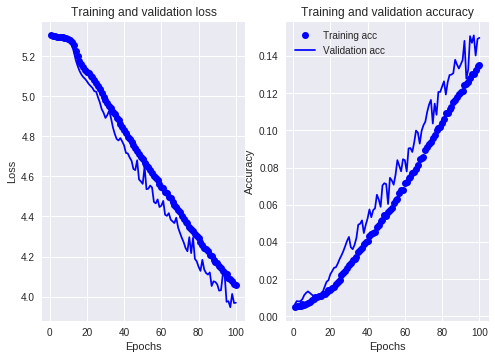

4885

4885

In [0]:
# Exp3
epoch =100
batch_size =1024
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result3.txt')
result[0].save(model_base_path+'model3.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 5, 5, 256)         884992    
__________

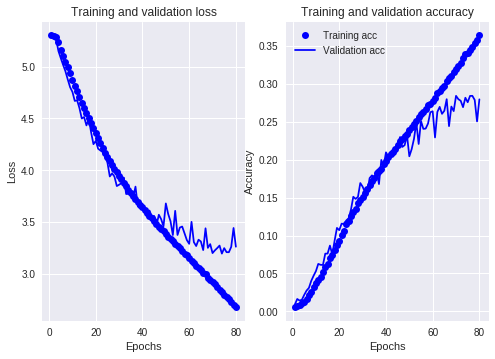

4621

In [0]:
# Exp4 increase the epoch
epoch =200
batch_size =256
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result4.txt')
result[0].save(model_base_path+'model4.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 5, 5, 256)         884992    
__________

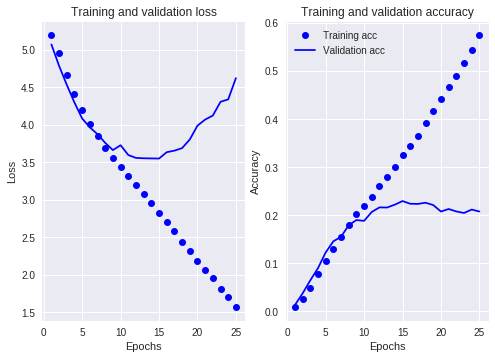

4891

In [0]:
# Exp5 with adam optimizer
epoch =100
batch_size =1024
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
# initiate adam optimizer
optimizer = 'adam'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result5.txt')
result[0].save(model_base_path+'model5.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 256)       393472    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 256)         884992    
__________

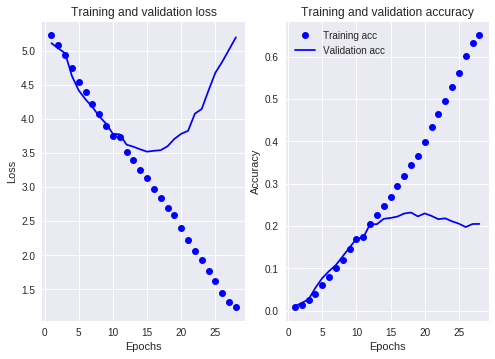

4896

In [0]:
#  
epoch =100
batch_size =2048
conv_filters_list =[96,256,384,384,256]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='adam'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result6.txt')
result[0].save(model_base_path+'model6.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 192)       14592     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 512)       1573376   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 768)         3539712   
_________________________________________________________________
conv2d_4 (Conv2D)    

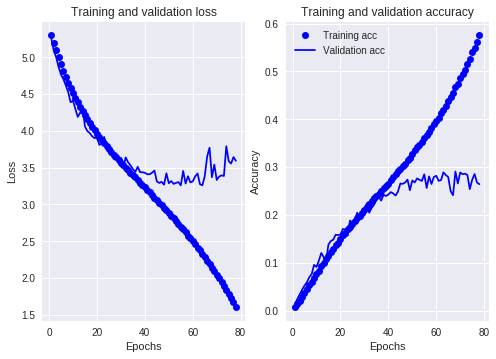

4758

In [0]:
# Exp7 increase the epoch
epoch =200
batch_size =256
conv_filters_list =[192,512,768,768,512]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result7.txt')
result[0].save(model_base_path+'model7.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 192)       14592     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 512)       1573376   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 768)         3539712   
_________________________________________________________________
conv2d_4 (Conv2D)    

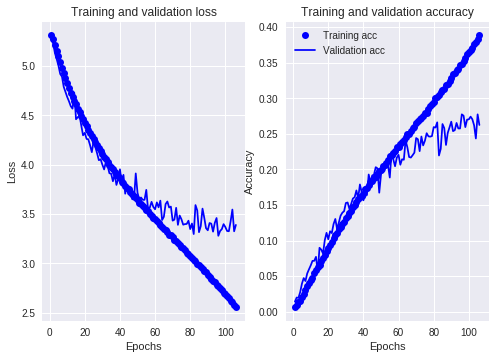

4893

In [11]:
# Exp8 increase the epoch
epoch =200
batch_size =512
conv_filters_list =[192,512,768,768,512]
dense_filters_list=[4096,4096]
conv_strides=(1,1)
pooling_strides=(2,2)
optimizer='sgd'
drop_out_rate=0.5
result = alexnet(x_train,y_train,x_test,y_test,epoch,batch_size,conv_filters_list,dense_filters_list,conv_strides,pooling_strides,optimizer,drop_out_rate)
write_result(result[1:4],base_path+'result8.txt')
result[0].save(model_base_path+'model8.h5')
plot_accuracy_loss(result[1])
del result
gc.collect()